<a href="https://colab.research.google.com/github/katemartian/Photometry_data_processing/blob/master/Photometry_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If you want to use this code, please cite our Jove paper:

__Martianova, E., Aronson, S., Proulx, C.D.__ [Multi-Fiber Photometry to Record Neural Activity in Freely Moving Animal.](https://www.jove.com/video/60278/multi-fiber-photometry-to-record-neural-activity-freely-moving). _J. Vis. Exp._ (152), e60278, doi:10.3791/60278 (2019).

# Functions

Run (Shift+Enter) the following 2 code cells in order to use the functions.

## z-score dF/F

In [0]:
'''
get_zdFF.py calculates standardized dF/F signal based on calcium-idependent 
and calcium-dependent signals commonly recorded using fiber photometry calcium imaging

Ocober 2019 Ekaterina Martianova ekaterina.martianova.1@ulaval.ca 

Reference:
  (1) Martianova, E., Aronson, S., Proulx, C.D. Multi-Fiber Photometry 
      to Record Neural Activity in Freely Moving Animal. J. Vis. Exp. 
      (152), e60278, doi:10.3791/60278 (2019)
      https://www.jove.com/video/60278/multi-fiber-photometry-to-record-neural-activity-freely-moving

'''

def get_zdFF(raw_reference,raw_signal,smooth_win,remove,lambd,porder,itermax): 
  '''
  Calculates z-score dF/F signal based on fiber photometry calcium-idependent 
  and calcium-dependent signals
  
  Input
      raw_reference - calcium-independent signal (usually 405-420 nm excitation)
      raw_signal - calcium-dependent signal (usually 465-490 nm excitation for 
                   green fluorescent proteins, or ~560 nm for red)
      smooth_win - window for moving average smooth 
      remove - the beginning of the traces with a big slope one would like to remove
      Inputs for airPLS:
      lambd - parameter that can be adjusted by user. The larger lambda is,  
              the smoother the resulting background, z
      porder - adaptive iteratively reweighted penalized least squares for baseline fitting
      itermax: maximum iteration times
  Output
      zdFF - z-score dF/F, numpy vector
  '''
  
  import numpy as np
  from sklearn.linear_model import Lasso

 # Smooth signal
  reference = np.array(raw_reference.rolling(window=smooth_win).mean()).reshape(len(raw_reference),1)
  signal = np.array(raw_signal.rolling(window=smooth_win).mean()).reshape(len(raw_signal),1)
  
 # Remove slope using airPLS algorithm
  r_base=airPLS(raw_reference.T,lambda_=lambd,porder=porder,itermax=itermax).reshape(len(raw_reference),1)
  s_base=airPLS(raw_signal.T,lambda_=lambd,porder=porder,itermax=itermax).reshape(len(raw_signal),1)  

 # Remove baseline and the begining of recording
  reference = (reference[remove:] - r_base[remove:])
  signal = (signal[remove:] - s_base[remove:])   

 # Standardize signals    
  z_reference = (reference - np.median(reference)) / np.std(reference)
  z_signal = (signal - np.median(signal)) / np.std(signal)
  
 # Align reference signal to calcium signal using non-negative robust linear regression
  lin = Lasso(alpha=0.0001,precompute=True,max_iter=1000,
              positive=True, random_state=9999, selection='random')
  lin.fit(z_reference, z_signal)
  z_reference_fitted = lin.predict(z_reference).reshape(len(z_reference),1) 

 # z dFF    
  zdFF = (z_signal - z_reference_fitted)
 
  return zdFF

## airPLS algorithm

Original code of airPLS

In [0]:
'''
airPLS.py Copyright 2014 Renato Lombardo - renato.lombardo@unipa.it
Baseline correction using adaptive iteratively reweighted penalized least squares

This program is a translation in python of the R source code of airPLS version 2.0
by Yizeng Liang and Zhang Zhimin - https://code.google.com/p/airpls

Reference:
Z.-M. Zhang, S. Chen, and Y.-Z. Liang, Baseline correction using adaptive iteratively 
reweighted penalized least squares. Analyst 135 (5), 1138-1146 (2010).

Description from the original documentation:
Baseline drift always blurs or even swamps signals and deteriorates analytical 
results, particularly in multivariate analysis.  It is necessary to correct baseline 
drift to perform further data analysis. Simple or modified polynomial fitting has 
been found to be effective in some extent. However, this method requires user 
intervention and prone to variability especially in low signal-to-noise ratio 
environments. The proposed adaptive iteratively reweighted Penalized Least Squares
(airPLS) algorithm doesn't require any user intervention and prior information, 
such as detected peaks. It iteratively changes weights of sum squares errors (SSE) 
between the fitted baseline and original signals, and the weights of SSE are obtained 
adaptively using between previously fitted baseline and original signals. This 
baseline estimator is general, fast and flexible in fitting baseline.


LICENCE
This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Lesser General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Lesser General Public License for more details.

You should have received a copy of the GNU Lesser General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>
'''

import numpy as np
from scipy.sparse import csc_matrix, eye, diags
from scipy.sparse.linalg import spsolve

def WhittakerSmooth(x,w,lambda_,differences=1):
    '''
    Penalized least squares algorithm for background fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        w: binary masks (value of the mask is zero if a point belongs to peaks and one otherwise)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background
        differences: integer indicating the order of the difference of penalties
    
    output
        the fitted background vector
    '''
    X=np.matrix(x)
    m=X.size
    i=np.arange(0,m)
    E=eye(m,format='csc')
    D=E[1:]-E[:-1] # numpy.diff() does not work with sparse matrix. This is a workaround.
    W=diags(w,0,shape=(m,m))
    A=csc_matrix(W+(lambda_*D.T*D))
    B=csc_matrix(W*X.T)
    background=spsolve(A,B)
    return np.array(background)

def airPLS(x, lambda_=100, porder=1, itermax=15):
    '''
    Adaptive iteratively reweighted penalized least squares for baseline fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        lambda_: parameter that can be adjusted by user. The larger lambda is,
                 the smoother the resulting background, z
        porder: adaptive iteratively reweighted penalized least squares for baseline fitting
    
    output
        the fitted background vector
    '''
    m=x.shape[0]
    w=np.ones(m)
    for i in range(1,itermax+1):
        z=WhittakerSmooth(x,w,lambda_, porder)
        d=x-z
        dssn=np.abs(d[d<0].sum())
        if(dssn<0.001*(abs(x)).sum() or i==itermax):
            if(i==itermax): print('WARING max iteration reached!')
            break
        w[d>=0]=0 # d>0 means that this point is part of a peak, so its weight is set to 0 in order to ignore it
        w[d<0]=np.exp(i*np.abs(d[d<0])/dssn)
        w[0]=np.exp(i*(d[d<0]).max()/dssn) 
        w[-1]=w[0]
    return z


# Your data

Run the cell to mount disk if you work with Google Colab

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Import libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Read your file to a dataframe

In [0]:
# Folder with your files
folder = '/content/drive/My Drive/' # Modify it depending on where your file is located
# File name
file_name = 'example.csv'   # Change to your data file
# Read the file
df = pd.read_csv(folder+file_name,index_col=False) # Adjust this line depending on your data file
df.head()

,Frame_410nm,MeanInt_410nm,Time_410nm,Realtime_410nm,Frame_470nm,MeanInt_470nm,Time_470nm,Realtime_470nm
0,2,1338.081287,0.1,14:51.6,1,951.292328,0.05,14:51.5
1,4,1026.983699,0.2,14:51.7,3,949.623125,0.15,14:51.6
2,6,1026.795914,0.3,14:51.8,5,948.962399,0.25,14:51.7
3,8,1026.615084,0.4,14:51.9,7,947.668768,0.35,14:51.8
4,10,1026.469028,0.5,14:52.0,9,947.174962,0.45,14:51.9


Choose from the dataframe calcium dependent and independent signals

In [0]:
# Adjust these lines depending on your dataframe
raw_reference = df['MeanInt_410nm'][1:]
raw_signal = df['MeanInt_470nm'][1:]

Plot the raw data

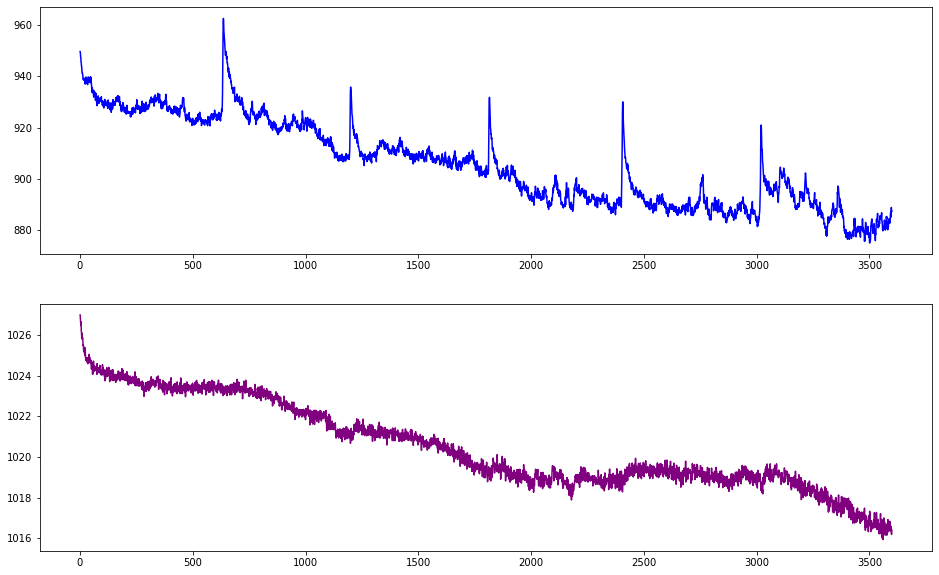

In [0]:
fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(211)
ax1.plot(raw_signal,'blue',linewidth=1.5)
ax2 = fig.add_subplot(212)
ax2.plot(raw_reference,'purple',linewidth=1.5)

# Use the function

Call the function

In [0]:
zdFF = get_zdFF(raw_reference,raw_signal,smooth_win=10,lambd=5e4,porder=1,itermax=50,remove=200)

Plot the result

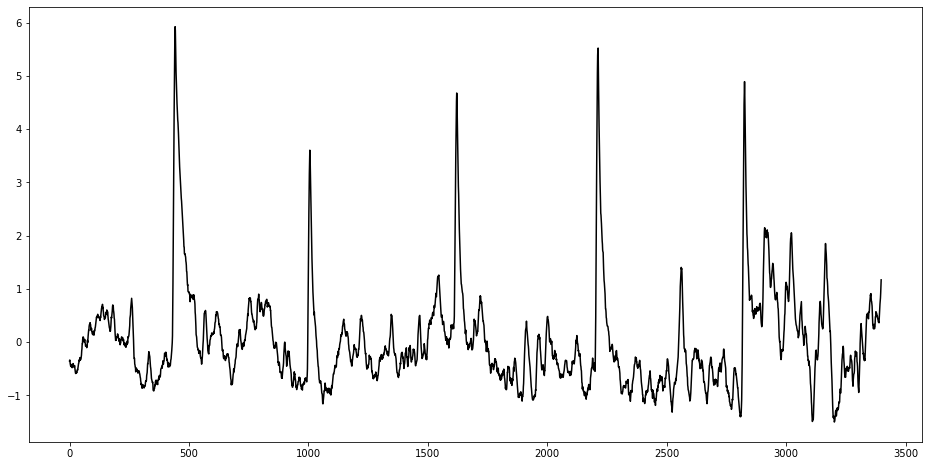

In [0]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111)
ax1.plot(zdFF,'black',linewidth=1.5)

# Analysis step by step

Smooth

In [0]:
smooth_win = 10
reference = np.array(raw_reference.rolling(window=smooth_win).mean()).reshape(len(raw_reference),1)
signal = np.array(raw_signal.rolling(window=smooth_win).mean()).reshape(len(raw_signal),1)

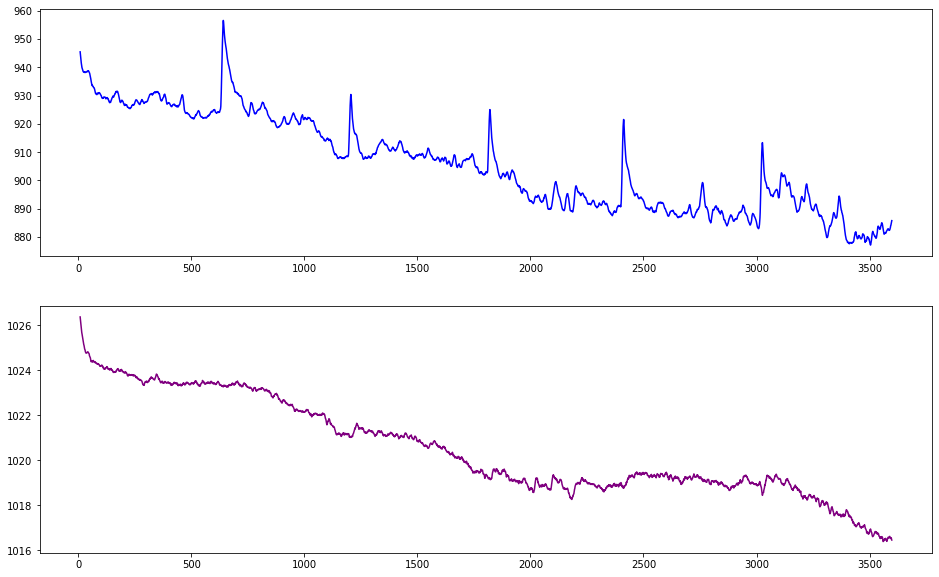

In [0]:
fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(211)
ax1.plot(signal,'blue',linewidth=1.5)
ax2 = fig.add_subplot(212)
ax2.plot(reference,'purple',linewidth=1.5)

Find the baseline

In [0]:
lambd = 5e4 # Adjust lambda to get the best fit
porder = 1
itermax = 50
r_base=airPLS(raw_reference.T,lambda_=lambd,porder=porder,itermax=itermax).reshape(len(raw_reference),1)
s_base=airPLS(raw_signal.T,lambda_=lambd,porder=porder,itermax=itermax).reshape(len(raw_signal),1) 

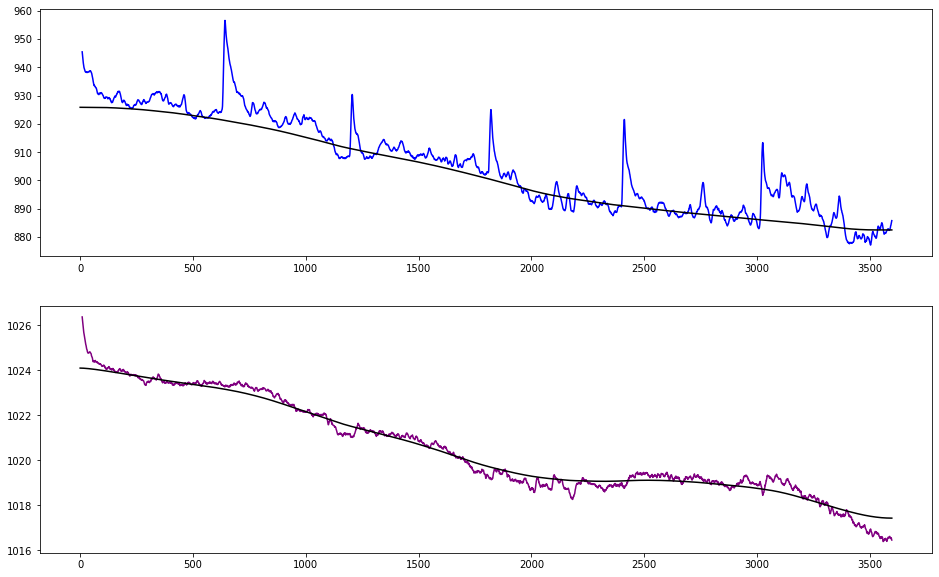

In [0]:
fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(211)
ax1.plot(signal,'blue',linewidth=1.5)
ax1.plot(s_base,'black',linewidth=1.5)
ax2 = fig.add_subplot(212)
ax2.plot(reference,'purple',linewidth=1.5)
ax2.plot(r_base,'black',linewidth=1.5)

Remove the baseline

In [0]:
remove=200
reference = (reference[remove:] - r_base[remove:])
signal = (signal[remove:] - s_base[remove:])  

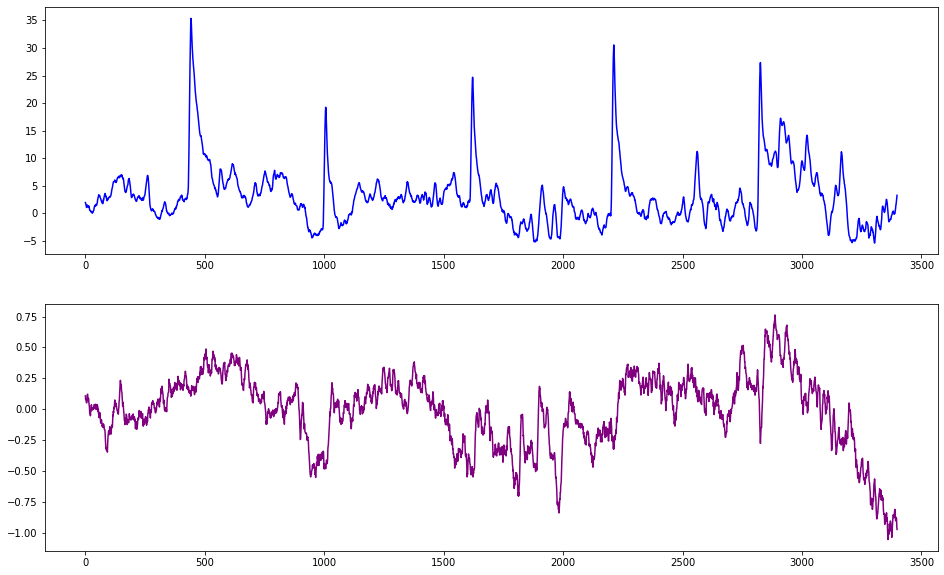

In [0]:
fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(211)
ax1.plot(signal,'blue',linewidth=1.5)
ax2 = fig.add_subplot(212)
ax2.plot(reference,'purple',linewidth=1.5)

Standardize signals

In [0]:
z_reference = (reference - np.median(reference)) / np.std(reference)
z_signal = (signal - np.median(signal)) / np.std(signal)

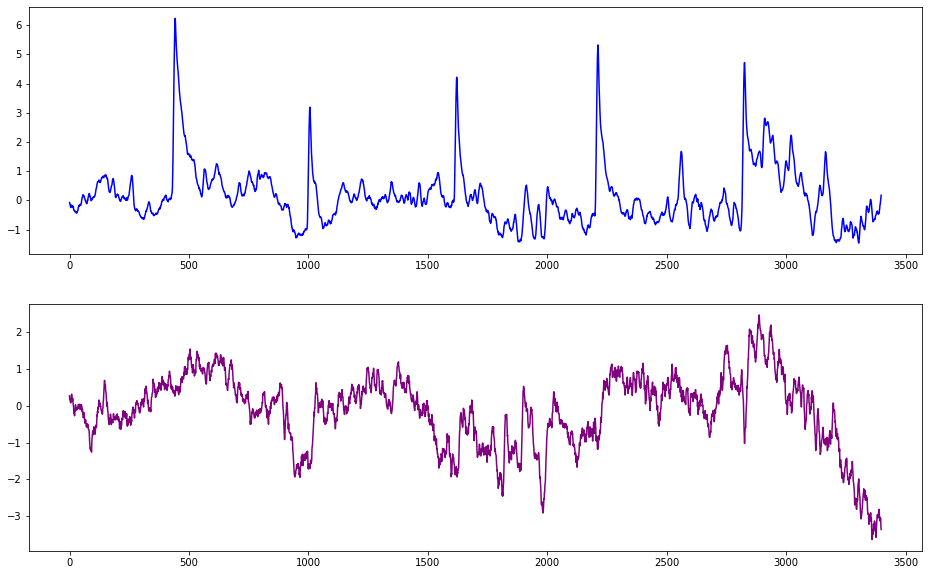

In [0]:
fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(211)
ax1.plot(z_signal,'blue',linewidth=1.5)
ax2 = fig.add_subplot(212)
ax2.plot(z_reference,'purple',linewidth=1.5)

Align reference signal to calcium signal using linear regression

In [0]:
from sklearn.linear_model import Lasso
lin = Lasso(alpha=0.0001,precompute=True,max_iter=1000,
            positive=True, random_state=9999, selection='random')
lin.fit(z_reference, z_signal)
z_reference_fitted = lin.predict(z_reference).reshape(len(z_reference),1)

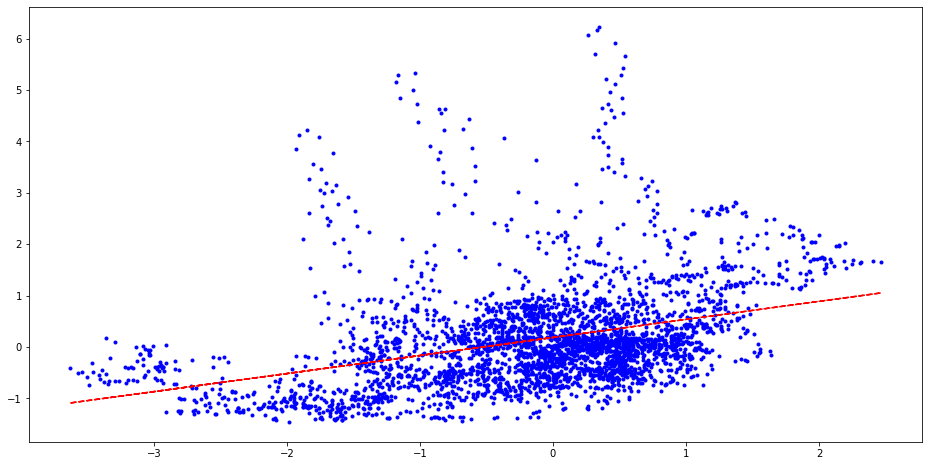

In [0]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111)
ax1.plot(z_reference,z_signal,'b.')
ax1.plot(z_reference,z_reference_fitted, 'r--',linewidth=1.5)

Plot aligned data

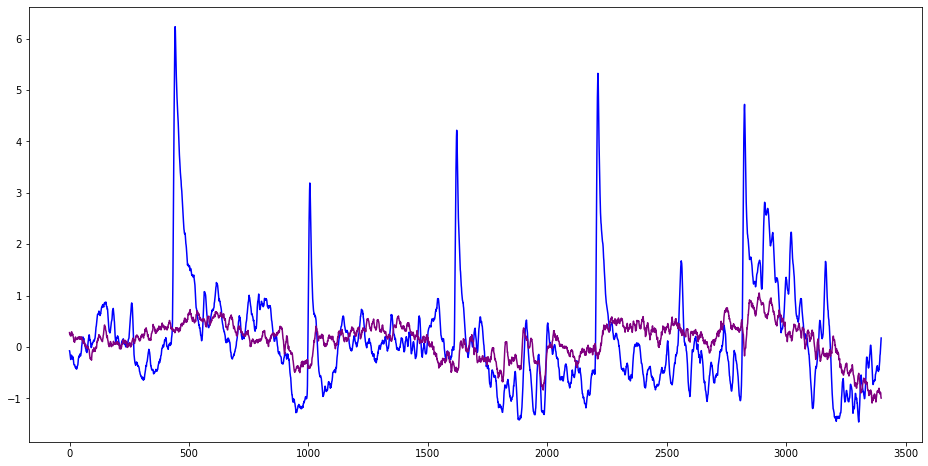

In [0]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111)
ax1.plot(z_signal,'blue')
ax1.plot(z_reference_fitted,'purple')

Calculate z-score dF/F

In [0]:
zdFF = (z_signal - z_reference_fitted)

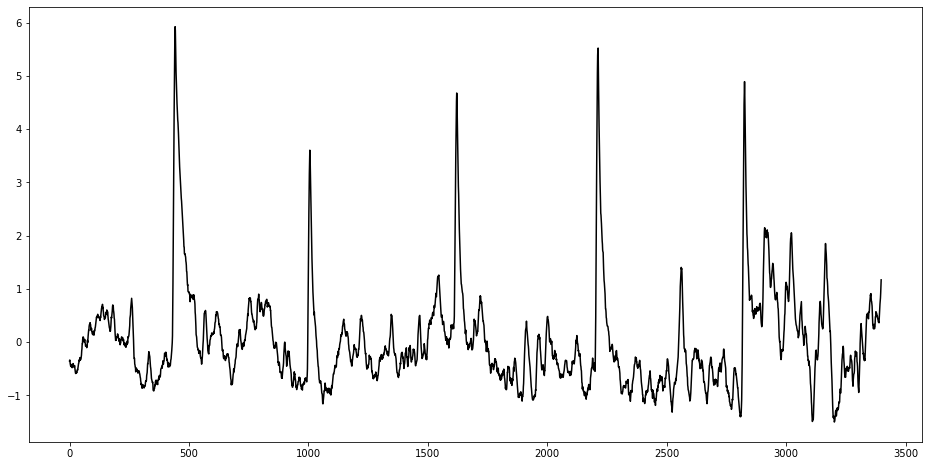

In [0]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111)
ax1.plot(zdFF,'black')

# Contact us

If you have any questions please contact us:
ekaterina.martianova.1@ulaval.ca